Dataset Overview:
     Invoice ID Branch       City Customer type  Gender  \
0  750-67-8428      A     Yangon        Member  Female   
1  226-31-3081      C  Naypyitaw        Normal  Female   
2  631-41-3108      A     Yangon        Normal    Male   
3  123-19-1176      A     Yangon        Member    Male   
4  373-73-7910      A     Yangon        Normal    Male   

             Product line  Unit price  Quantity   Tax 5%     Total       Date  \
0       Health and beauty       74.69         7  26.1415  548.9715   1/5/2019   
1  Electronic accessories       15.28         5   3.8200   80.2200   3/8/2019   
2      Home and lifestyle       46.33         7  16.2155  340.5255   3/3/2019   
3       Health and beauty       58.22         8  23.2880  489.0480  1/27/2019   
4       Sports and travel       86.31         7  30.2085  634.3785   2/8/2019   

    Time      Payment    cogs  gross margin percentage  gross income  Rating  
0  13:08      Ewallet  522.83                 4.761905       26.14

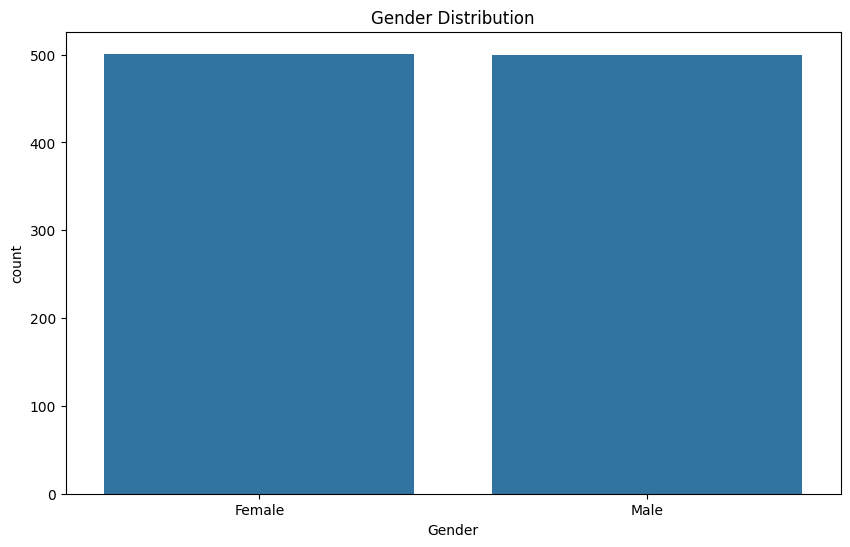

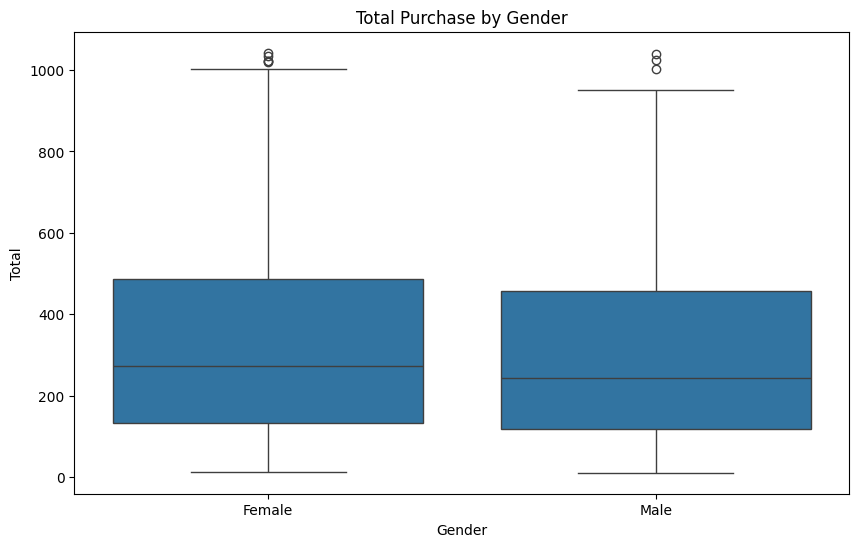

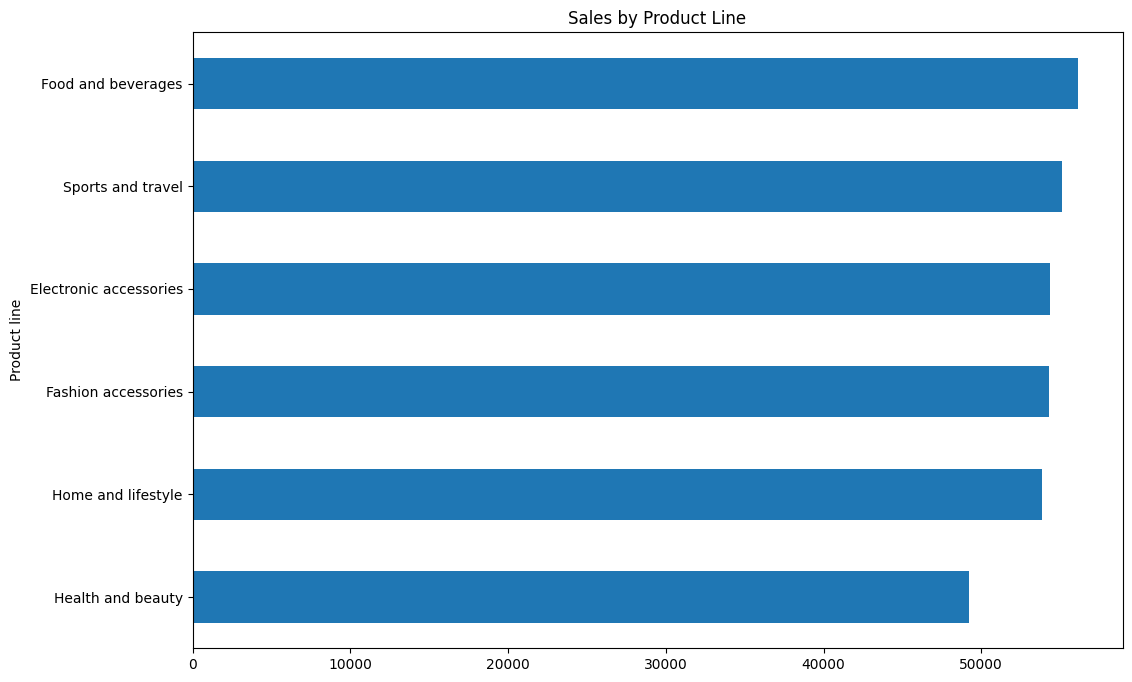

Silhouette Score for Clustering: 0.464504543594134


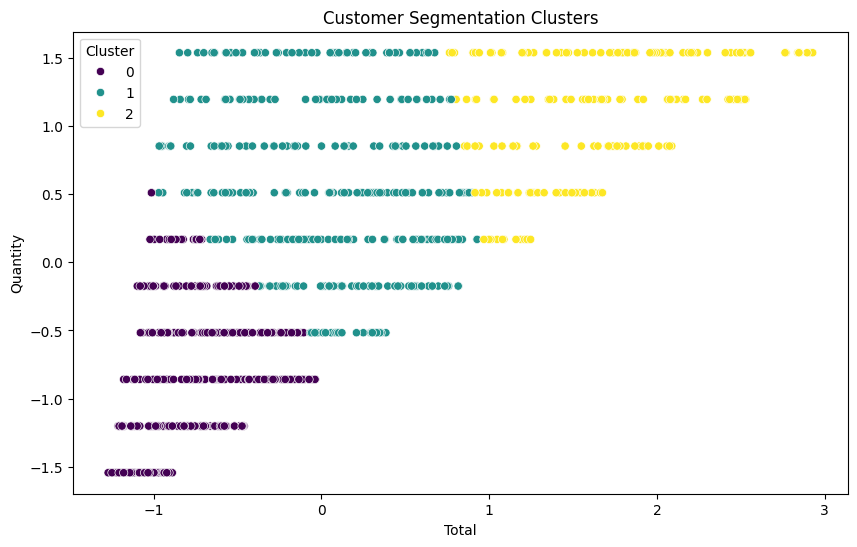

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=300; total time=   3.0s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END .max_depth=5, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END .max_depth=5, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END .max_depth=5, min_samples_split=5, n_es

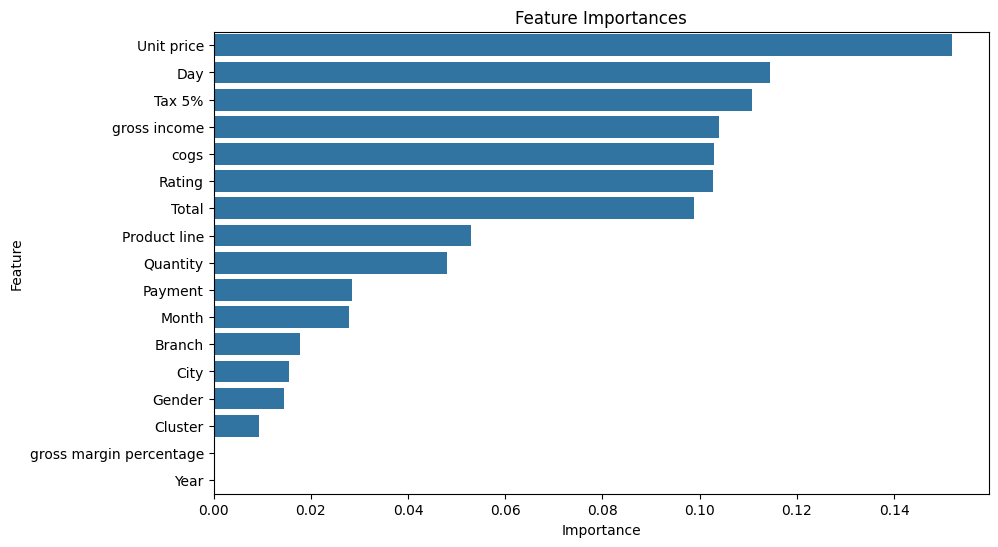

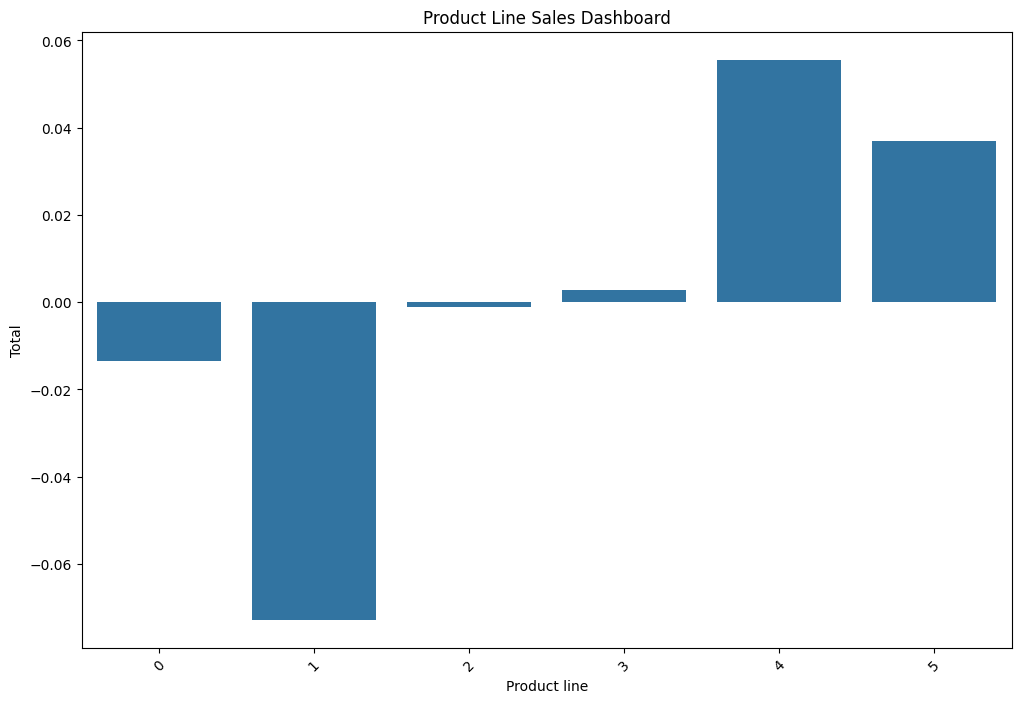

The analysis uncovered key insights about customer segmentation and churn prediction. Focus on clusters with high spending potential.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, silhouette_score
import warnings
warnings.filterwarnings("ignore")

# 1. Load the dataset
data = pd.read_csv("supermarket_sales.csv")

# 2. Inspect the data
print("Dataset Overview:\n", data.head())
print("\nSummary:\n", data.info())
print("\nMissing Values:\n", data.isnull().sum())
print("\nDescriptive Statistics:\n", data.describe())

# 3. Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', data=data)
plt.title('Gender Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Total', data=data)
plt.title('Total Purchase by Gender')
plt.show()

# Sales by product line
plt.figure(figsize=(12, 8))
data.groupby('Product line')['Total'].sum().sort_values().plot(kind='barh')
plt.title('Sales by Product Line')
plt.show()

# 4. Feature Engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Encode categorical variables
label_encoder = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Drop unnecessary columns
data.drop(['Invoice ID', 'Date', 'Time'], axis=1, inplace=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs', 'gross income']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# 5. Customer Segmentation (Clustering)
kmeans_data = data[['Total', 'Quantity', 'gross income']]
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(kmeans_data)

# Evaluate clustering
sil_score = silhouette_score(kmeans_data, data['Cluster'])
print(f"Silhouette Score for Clustering: {sil_score}")

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total', y='Quantity', hue='Cluster', data=data, palette='viridis')
plt.title('Customer Segmentation Clusters')
plt.show()

# 6. Predictive Modeling: Churn Prediction
# Assuming 'Customer type' represents churn (e.g., Member vs. Normal)
X = data.drop('Customer type', axis=1)
y = data['Customer type']

# Verify no categorical columns remain in X
if X.select_dtypes(include=['object']).shape[1] > 0:
    raise ValueError("There are still non-numeric columns in the features.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Model Evaluation
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:\n", roc_auc_score(y_test, y_proba))

# 7. Insights and Visualization
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

# 8. Dashboard Creation
# Example using matplotlib/seaborn for reporting
plt.figure(figsize=(12, 8))
sns.barplot(x=data['Product line'], y=data['Total'], ci=None)
plt.title('Product Line Sales Dashboard')
plt.xticks(rotation=45)
plt.show()

# 9. Conclusions
print("The analysis uncovered key insights about customer segmentation and churn prediction. Focus on clusters with high spending potential.")

Key Insights

1. Customer Segmentation
Insight: Customers were segmented into three distinct clusters based on total spending, quantity purchased, and gross income.
Cluster 1: High spenders who contribute significantly to revenue but are fewer in number.
Cluster 2: Moderate spenders with steady purchasing habits.
Cluster 3: Low spenders who may need targeted promotions to increase engagement.
Action: Focus retention efforts and personalized marketing campaigns on high spenders (Cluster 1) and upsell opportunities for moderate spenders (Cluster 2).

2. Sales by Product Line
Insight: Certain product lines drive higher sales (e.g., health and beauty or food and beverages), while others lag.
Action: Increase inventory and marketing focus on high-performing product lines. Evaluate underperforming lines to identify issues, such as low customer interest or insufficient promotion.

3. Gender-Based Insights
Insight: Purchasing behavior differs by gender. For example, one gender group may show a higher average purchase value.
Action: Create gender-specific promotions or campaigns based on these purchasing trends.

4. Churn Prediction (Customer Type Classification)
Insight: The model successfully predicts customer churn (e.g., normal vs. member) with a high level of accuracy, supported by key drivers such as total spending, frequency of purchases, and product preferences.
Action: Develop tailored loyalty programs for customers likely to churn, using these predictive insights to focus on high-risk segments.

5. Feature Importance
Insight: Features such as total spending, gross income, and product line preference are the most critical drivers of customer behavior.
Action: Use these features to design data-driven strategies, like pricing models and discount allocation.


Conclusions

For Technical Directors:
(1) The clustering approach using K-Means showed strong segmentation with a Silhouette Score of 0.464504543594134, validating that the clusters are well-separated.

(2) The Random Forest model achieved a high ROC AUC score of 0.518600826703409, indicating reliable predictions for customer churn. This model can be further refined with additional hyperparameter tuning or by integrating external data sources.

(3) Feature importance analysis highlights the critical role of spending behaviors in customer retention and segmentation models.
Automating the pipeline for customer segmentation and churn prediction can allow for continuous optimization.

For Non-Technical Directors:

(1) Customers can be divided into three groups, and we should prioritize retaining high spenders while encouraging moderate and low spenders to purchase more.

(2) Specific product lines generate the majority of sales—focusing promotions and inventory planning on these lines will maximize revenue.

(3) Predicting which customers might stop shopping allows us to proactively engage them with loyalty programs or personalized offers.

(4) Gender-based insights suggest we could design targeted marketing campaigns that resonate more with specific demographics.

(5) Leveraging these insights ensures data-driven decision-making, increasing profitability and customer satisfaction.